In [3]:
import os
print(os.listdir("/kaggle/input"))
print(os.listdir("/kaggle/input/nasa-cmaps"))
print(os.listdir("/kaggle/input/nasa-cmaps/CMaps"))
print(os.listdir("/kaggle/input/nasa-cmaps/cmaps"))
print(os.listdir("/kaggle/input/nasa-cmaps/cmaps/CMaps"))

['nasa-cmaps']
['CMaps', 'cmaps']
['RUL_FD002.txt', 'test_FD003.txt', 'Damage Propagation Modeling.pdf', 'readme.txt', 'train_FD003.txt', 'test_FD004.txt', 'train_FD004.txt', 'x.txt', 'test_FD002.txt', 'train_FD001.txt', 'train_FD002.txt', 'RUL_FD001.txt', 'RUL_FD004.txt', 'RUL_FD003.txt', 'test_FD001.txt']
['CMaps']
['RUL_FD002.txt', 'test_FD003.txt', 'Damage Propagation Modeling.pdf', 'readme.txt', 'train_FD003.txt', 'test_FD004.txt', 'train_FD004.txt', 'x.txt', 'test_FD002.txt', 'train_FD001.txt', 'train_FD002.txt', 'RUL_FD001.txt', 'RUL_FD004.txt', 'RUL_FD003.txt', 'test_FD001.txt']


In [4]:
import os, math, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# stg1_設定與讀檔
## 固定隨機種子
SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)

## 資料路徑
BASE = "/kaggle/input/nasa-cmaps/CMaps"
print("Using data dir:", BASE)
print("Files:", sorted(os.listdir(BASE))[:8], "...")

## 欄位名稱
COLS = ["unit","time","op1","op2","op3"] + [f"s{i}" for i in range(1,22)]

## 讀檔
def read_fd(fd: str):
    tr = pd.read_csv(f"{BASE}/train_{fd}.txt", sep=r"\s+", header=None)
    te = pd.read_csv(f"{BASE}/test_{fd}.txt", sep=r"\s+", header=None)
    rl = pd.read_csv(f"{BASE}/RUL_{fd}.txt", sep=r"\s+", header=None)
    tr.columns = COLS; te.columns = COLS; rl.columns = ["RUL"]
    return tr, te, rl

2025-11-02 09:30:12.589264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762075812.940766      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762075813.051800      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using data dir: /kaggle/input/nasa-cmaps/CMaps
Files: ['Damage Propagation Modeling.pdf', 'RUL_FD001.txt', 'RUL_FD002.txt', 'RUL_FD003.txt', 'RUL_FD004.txt', 'readme.txt', 'test_FD001.txt', 'test_FD002.txt'] ...


In [5]:
# stg2_產生 RUL 標籤
## 2.1 對訓練資料生成當下的 RUL, 對訓練資料自己算出每個時間點的剩餘壽命
def add_train_rul(df):
    out = []
    for uid, g in df.groupby("unit"): # 按照引擎編號（unit）分組
        g = g.sort_values("time").copy() # 依時間排序
        g["RUL"] = g["time"].max() - g["time"] # g["time"].max()=該引擎壞掉的時刻 , g["time"]=該引擎那一時刻的cycle, 相減得到還剩多少圈會壞
        out.append(g) # 計算出還剩多少圈會壞的結果放進out
    return pd.concat(out, axis=0) # 把所有引擎結果合併成表
    
## 2.2 計算每筆資料(引擎)真實剩餘壽命 RUL
def make_test_rul(test_df, rul_last):
    out = []
    for (uid, g), r in zip(test_df.groupby("unit"), rul_last["RUL"].values): # 每台引擎最後時刻後還能跑的圈數
        g = g.sort_values("time").copy()
        g["RUL"] = (g["time"].max() - g["time"]) + int(r) # 計算距離真正壞掉還有多少圈 = 這台引擎內部每個時間點「距離最後一筆資料」的距離 + r(最後一筆後還能跑的圈數)
        out.append(g)
    return pd.concat(out, axis=0)

## 2.3 把過大的 RUL 以上限裁切, 目前設定cap=None(因為若RUL非常大模型會太偏向學習大數值, 忽略壽命短的情況, 故設)
def cap_rul(df, cap=None):
    if cap is not None:
        df["RUL"] = df["RUL"].clip(upper=cap)
    return df

# sgt3_產生序列切片
## 3.1 要使用的特徵欄位
FEATS = ["op1","op2","op3"] + [f"s{i}" for i in range(1,22)]
## 3.2 把一長串感測數據切成很多固定長度的時間片段, 每片段對應一個「當下的剩餘壽命（RUL）」作為訓練樣本
def make_sequences(df, seq_len=30, feat_cols=None, label_col="RUL"):
    X, y = [], [] # X: 放時間序列的感測值（模型輸入）, y: 放每個序列對應的目標（RUL，模型要預測的值）
    for _, g in df.groupby("unit"): # 每台引擎
        g = g.sort_values("time") # 按時間排序
        A = g[feat_cols].values.astype("float32") #該引擎所有時間點的感測器資料
        T = g[label_col].values.astype("float32") #該引擎對應的剩餘壽命（RUL）
        if len(g) <= seq_len: # 如果這台引擎的資料比設定的序列長度還短則跳過
            continue
        for i in range(len(g) - seq_len):
            # A:感測器資料的 numpy array (A(該引擎有XX個時間點, 每個時間點有XX個感測器特徵))
            X.append(A[i:i+seq_len]) # 每次取固定seq_len長度的時間切片(例如 取1~30)的固定感測器數量
            # T: RUL（剩餘壽命）向量
            y.append(T[i+seq_len]) # 該時間切片後一個時間點的 RUL (例如 31的RUL)
    return np.asarray(X), np.asarray(y) # 把所有樣本轉成 numpy array


In [7]:
# stg4_定義模型
## 4.1 LSTM 
def build_lstm(n_feat, seq_len):
    m = Sequential([
        tf.keras.Input(shape=(seq_len, n_feat)), #(時間長度, 感測器數)
        LSTM(64, return_sequences=True), # 第一層LSTM：輸出每一時刻的隱狀態
        Dropout(0.2),
        LSTM(32),# 第二層LSTM：只保留最後一個時間點的輸出（shape: 64）
        Dense(1) # 把 32 維特徵壓成一個實數 → 預測剩餘壽命 RUL
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)  # 梯度裁剪
    m.compile(optimizer=opt, loss="mse")
    return m
    
## 4.2 Transformer encoder
def build_transformer(n_feat, seq_len):
    inp = Input(shape=(seq_len, n_feat)) # 輸入時間序列
    x = MultiHeadAttention(num_heads=4, key_dim=32)(inp, inp) # 學習時間點之間的關聯性
    x = LayerNormalization()(x) # 正規化
    x = Dropout(0.2)(x) # 正則化
    x = Dense(32, activation="relu")(x) # 將特徵非線性轉換成 64 維
    out = Dense(1)(x[:, -1, :]) # 取最後一個時間步的輸出來預測 RUL
    m = Model(inp, out)
    m.compile(optimizer="adam", loss="mse") # 設定訓練方式
    return m

## 4.3 模型訓練設定
ES = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
RL = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

FD_LIST = ["FD001", "FD002", "FD003", "FD004"] # 逐一資料集獨立訓練/評估
SEQ_LEN  = 32       # shorter for speed
RUL_CAP  = 130
EPOCHS   = 10        # fewer epochs for speed
BATCH    = 128       # larger batch = faster GPU usage

summary_rows = [] # 蒐集各 FD 的分數
per_fd_models = {} # 保存 scaler 與兩模型，供後續畫圖



===== FD001 | Train seq: (17431, 32, 24) | Test seq: (9897, 32, 24) =====


2025-11-02 09:32:24.535365: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 7725.4727 - val_loss: 7645.0283 - learning_rate: 0.0010
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 6655.4272 - val_loss: 7035.9634 - learning_rate: 0.0010
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 6102.1489 - val_loss: 6461.8716 - learning_rate: 0.0010
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 5581.8716 - val_loss: 5919.5122 - learning_rate: 0.0010
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 5091.6108 - val_loss: 5406.7256 - learning_rate: 0.0010
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 4630.2544 - val_loss: 4922.7095 - learning_rate: 0.0010
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 4196.7710 - val_loss: 4467.8838 - learning_rate: 0.0010
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 3790.2383 - val_loss: 4037.6458 - learning_rate: 0.0010
Epoch 9/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 34

,Dataset,LSTM_MAE,LSTM_RMSE,Trans_MAE,Trans_RMSE
0,FD001,60.889999,67.089996,14.830000,19.080000
1,FD002,37.160000,40.630001,20.150000,24.200001
2,FD003,58.660000,63.509998,11.500000,15.920000
3,FD004,34.950001,37.259998,17.290001,21.900000


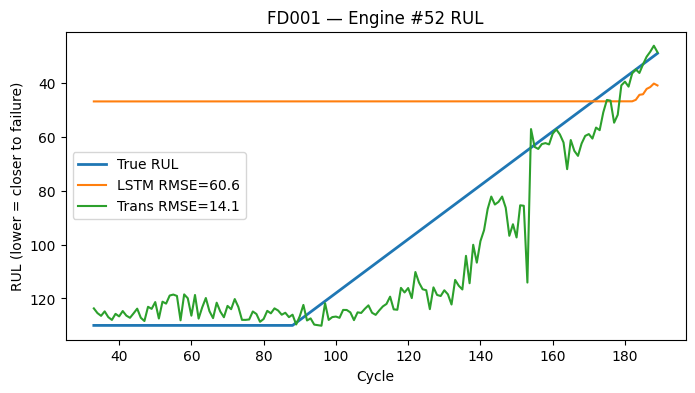

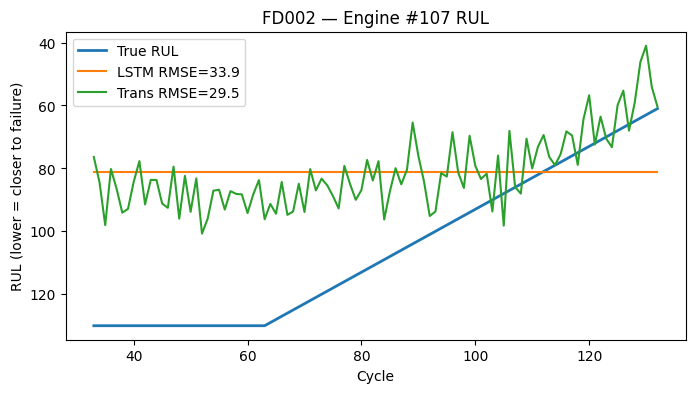

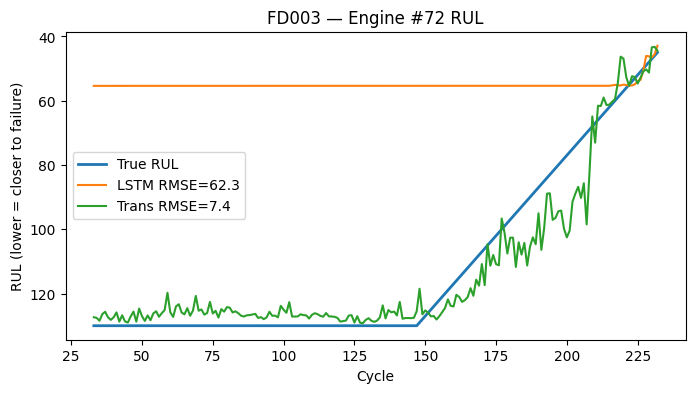

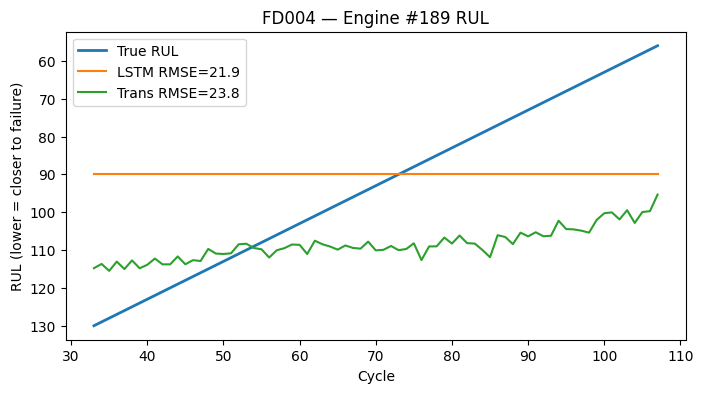

In [8]:
# stg5_主流程：逐個 FD 訓練與評估
## 5.1 讀檔：依序讀入 FD001/2/3/4
for FD in FD_LIST:
    try:
        train, test, rul_last = read_fd(FD)
    except FileNotFoundError:
        print(f"[{FD}] files missing — skip.")
        continue
    ## 產生 RUL，並（可選）做上限裁切
    train = cap_rul(add_train_rul(train), RUL_CAP) # add_train_rul計算出每一筆時刻的 RUL=最大時間 − 當前時間
    test  = cap_rul(make_test_rul(test, rul_last), RUL_CAP) # make_test_rul計算每筆資料(引擎)真實剩餘壽命 RUL
    ## 標準化：只用訓練集 fit
    scaler = StandardScaler().fit(train[FEATS])
    train[FEATS] = scaler.transform(train[FEATS])
    test[FEATS]  = scaler.transform(test[FEATS])
    ## 生成序列切片
    X_tr, y_tr = make_sequences(train, seq_len=SEQ_LEN, feat_cols=FEATS)
    X_te, y_te = make_sequences(test, seq_len=SEQ_LEN, feat_cols=FEATS)
    if len(X_tr)==0 or len(X_te)==0:
        print(f"[{FD}] Not enough sequence length — skip.")
        continue

    print(f"\n===== {FD} | Train seq: {X_tr.shape} | Test seq: {X_te.shape} =====")

    # LSTM訓練與評估
    lstm = build_lstm(n_feat=X_tr.shape[-1], seq_len=SEQ_LEN)
    lstm.fit(X_tr, y_tr, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH,
             callbacks=[ES, RL], verbose=1)
    yhat_l = lstm.predict(X_te, batch_size=512, verbose=0).ravel()
    mae_l = mean_absolute_error(y_te, yhat_l)
    rmse_l = mean_squared_error(y_te, yhat_l, squared=False)

    # Transformer訓練與評估
    trans = build_transformer(n_feat=X_tr.shape[-1], seq_len=SEQ_LEN)
    trans.fit(X_tr, y_tr, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH,
              callbacks=[ES, RL], verbose=1)
    yhat_t = trans.predict(X_te, batch_size=512, verbose=0).ravel()
    mae_t = mean_absolute_error(y_te, yhat_t)
    rmse_t = mean_squared_error(y_te, yhat_t, squared=False)
# 蒐集分數
    summary_rows.append({
        "Dataset": FD,
        "LSTM_MAE": round(mae_l, 2), "LSTM_RMSE": round(rmse_l, 2),
        "Trans_MAE": round(mae_t, 2), "Trans_RMSE": round(rmse_t, 2)
    })

    per_fd_models[FD] = dict(lstm=lstm, trans=trans, scaler=scaler,
                             X_te=X_te, y_te=y_te)

# 匯總各 FD 的 MAE/RMSE
summary = pd.DataFrame(summary_rows)
display(summary.sort_values("Dataset"))

# Visualization(真實 vs 預測 RUL)
def plot_example(fd: str, unit: int = None, max_points=400):
    train, test, rul = read_fd(fd)
    test = cap_rul(make_test_rul(test, rul), RUL_CAP)
    scaler = per_fd_models[fd]["scaler"]
    test[FEATS] = scaler.transform(test[FEATS])

    # Pick a random engine
    units = sorted(test["unit"].unique())
    uid = unit if unit in units else int(np.random.choice(units))
    g = test[test["unit"] == uid].sort_values("time")

    X, y = [], []
    arr = g[FEATS].values.astype("float32")
    tgt = g["RUL"].values.astype("float32")
    for i in range(len(g) - SEQ_LEN):
        X.append(arr[i:i+SEQ_LEN]); y.append(tgt[i+SEQ_LEN])
    X, y = np.asarray(X), np.asarray(y)

    lstm = per_fd_models[fd]["lstm"]
    trans = per_fd_models[fd]["trans"]
    p_l = lstm.predict(X, verbose=0).ravel()
    p_t = trans.predict(X, verbose=0).ravel()

    t = g["time"].values[SEQ_LEN:]
    k = min(max_points, len(t))

    plt.figure(figsize=(8,4))
    plt.plot(t[:k], y[:k],  label="True RUL", linewidth=2)
    plt.plot(t[:k], p_l[:k], label=f"LSTM RMSE={mean_squared_error(y[:k], p_l[:k], squared=False):.1f}")
    plt.plot(t[:k], p_t[:k], label=f"Trans RMSE={mean_squared_error(y[:k], p_t[:k], squared=False):.1f}")
    plt.gca().invert_yaxis()
    plt.title(f"{fd} — Engine #{uid} RUL")
    plt.xlabel("Cycle"); plt.ylabel("RUL (lower = closer to failure)")
    plt.legend(); plt.show()

for fd in summary["Dataset"]:
    plot_example(fd)
